# Neural Network from Scratch


## Importing libraries

We will use the lower resolution MINST data set

In [1]:
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from collections import Sequence
import matplotlib.pyplot as plt 

from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits              # The MNIST data set
from sklearn.preprocessing import StandardScaler      # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard train test split to prevent overfitting and choose hyperparameters

DEBUG = True

## Exploring the dataset

The shape of the digits dataset: (1797, 64)


<Figure size 432x288 with 0 Axes>

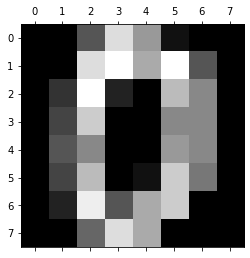

In [2]:
# load all the digits dataset from the sklearn library

digits = load_digits()
X, y = digits.data, digits.target
print("The shape of the digits dataset:", X.shape)

plt.gray()  # set colormap to gray
plt.matshow(digits.images[0])
plt.show()

## Scale the dataset
To speed the weight convergence, the training features must be scaled to have a mean of 0 and unit variance

In [3]:
# Using the StandardScaler to standardize our X_feat
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# Looking the new features after scaling
X_scaled

array([[ 0.        , -0.33501649, -0.04308102, ..., -1.14664746,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -1.09493684, ...,  0.54856067,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -1.09493684, ...,  1.56568555,
         1.6951369 , -0.19600752],
       ...,
       [ 0.        , -0.33501649, -0.88456568, ..., -0.12952258,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -0.67419451, ...,  0.8876023 ,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649,  1.00877481, ...,  0.8876023 ,
        -0.26113572, -0.19600752]])

## Creating training and test datasets

We split the data into training and test data sets with 60-40 split. 

We will train the neural network with the training dataset, and evaluate our neural network with the test dataset 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.40, random_state=1)

## Setting up the output layer

### One hot encoding

In [5]:
def convert_y_to_vect(y):
    """
    One Hot Encoding for target
    Converts into a 10 element array
    
    y can be an integer or a Sequence of integers
    """
    if isinstance(y, int):
        return np.array([1 if i==y else 0 for i in range(10)])
    elif isinstance(y, Sequence) or isinstance(y, np.ndarray):
        return np.array([[1 if i==target else 0 for i in range(10)] for target in y])

Converting the training and test targets to vectors 

In [6]:
# convert digits to vectors using the func above
y_train_vect, y_test_vect = convert_y_to_vect(y_train), convert_y_to_vect(y_test)

In [7]:
if DEBUG:
    print(y_train[0:4])
    print((y_train_vect[0:4]))

[3 5 4 4]
[[0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


## Creating the neural network

### The activation function and its derivative

We use the Sigmoid Activation function

$\sigma(z) = \frac{1}{1+e^{-z}}$

And use its derivative

$\sigma'(z) = \sigma(z)(1-\sigma(z))$

In [8]:
def sigmoid(z):
    return 1/(1+np.e**(-z))

def sigmoid_deriv(z):
    return sigmoid(z) * (1-sigmoid(z))

### Creating and initializing W and b

W = weights of the neurons

b = biases of the neurons

The weights in W are different so that during back propagation, the nodes on a level will have different gradients and thus have different update values.

The weights are randomly initialized from the uniform range \[0.0, 1.0\). The weights have to be small as the sigmoid flats out for large inputs

In [29]:
def init_weight_and_bias(nn_structure: List[int]):
    """
    nn_structure is a list that reprs the number of neurons in the NN layer
    We use the Kaiming Initialization for the weights
    """
    weights, bias = {}, {}
    
    # first layer is input layer so we do not save weights for it
    for layer, n_neurons in enumerate(nn_structure[1:], start=1):
        weights[layer] = np.random.random((n_neurons, nn_structure[layer-1])) / np.sqrt(n_neurons)
        bias[layer] = np.random.random(n_neurons)
        
    return weights, bias

### Initializing the weight and bias gradient dicts $\triangledown W$ and $\triangledown b$


In [10]:
def init_weight_and_bias_gradients(nn_structure: List[int]):
    delta_W, delta_b = {}, {}
    
    for layer, n_neurons in enumerate(nn_structure[1:], start=1):
        delta_W[layer] = np.zeros((n_neurons, nn_structure[layer-1]))
        delta_b[layer] = np.zeros(n_neurons)
        
    return  delta_W, delta_b

## Feed forward

The feed_forward function returns the values of $a$ and $z$

In [11]:
def feed_forward(x, W, b):
    """
    x is a single data point / 1D array
    a,z ignore input layer values
    """
    # a in layer 1 is the input x itself
    a = {1:x} # holds values of 'a' for all layers, a = func_activation(z)
    z = {}    # holds values of 'z' for all layers, z = Wx + b
    X_feat = x

    for layer, (weight,bias) in enumerate(zip(W, b), start=2): 
        z[layer] = W[layer-1].dot(X_feat) + b[layer-1]
        a[layer] = sigmoid(z[layer])
        X_feat = a[layer]
        
    return a, z

## Computing $\delta$

$\delta^{(s_l)}$ is computed in "calculate_out_layer_delta"  

$delta^{nl} = -(y_i - a_i^{nl}) * f'(z_i^{nl})$

$\delta^{(\ell)}$ is computed for the hidden layers in "calculate_hidden_delta" 
    
$delta^{l} = (transpose(W^{l}) * delta^{l+1}) * f'(z^{l})$

In [12]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return  -(y-a_out) * sigmoid_deriv(z_out)


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return (w_l.T@delta_plus_1) * sigmoid_deriv(z_l)

## The Back Propagation Algorithm


In [26]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25):
    """
    X msut be np.ndarray
    """
    W, b = init_weight_and_bias(nn_structure)
    epoch = 0
    m, n = X.shape
    mse_cost_overtime = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    # while the counter is less than the max iterations:
    for epoch in tqdm(range(iter_num)):
        delta_W, delta_b = init_weight_and_bias_gradients(nn_structure)
        cost = 0
        
        for data_idx, data in enumerate(X):
            # feed forward pass saves a and z values to be used in gradient descent
            a, z = feed_forward(data, W, b)
            deltas = {}
            # loop from n-1 to 1 backpropagating the errors
            for layer in range(len(nn_structure),0,-1):
                if layer == len(nn_structure): # layer is output layer
                    deltas[layer] = calculate_out_layer_delta(y[data_idx,:], a[layer], z[layer])
                    # squared error calculation
                    cost += np.sqrt(np.sum((a[layer] - y[data_idx,:])**2))
                else:
                    if layer > 1: # layer is hidden layer
                        deltas[layer] = calculate_hidden_delta(deltas[layer+1], W[layer], z[layer])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    delta_W[layer] +=  (deltas[layer+1][:, np.newaxis] @ a[layer][:,np.newaxis].T)
                    
                    # hint: you can use np.newaxis to increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    delta_b[layer] +=  deltas[layer+1]

        # perform the gradient descent step for the weights in each layer
        for layer in range(len(nn_structure)-1,0,-1):
            W[layer] += -alpha*(delta_W[layer]/m)
            b[layer] += -alpha*(delta_b[layer]/m)

        mse_cost = cost / m
        mse_cost_overtime.append(mse_cost)
        
        # print the iteration number for every 1000 iter
        if epoch % 500 == 0:
            print("At iteration", epoch, "loss is ", mse_cost_overtime[epoch])

    return W, b, mse_cost_overtime

In [14]:
def predict_y(W, b, X, n_layer_idx):
    m, n = X.shape
    y_pred = np.zeros((m,))

    for i, data in enumerate(X):
        a, _ = feed_forward(data, W, b)
        y_pred[i] = np.argmax(a[n_layer_idx])

    return y_pred

## Running the neural network

Our code assumes the size of each layer in our network is held in a list.  The input layer will have 64 neurons (one for each pixel in our 8 by 8 pixelated digit).  Our hidden layer has 30 neurons (you can change this value).  The output layer has 10 neurons.

Next we create the python list to hold the number of neurons for each level and then run the neural network code with our training data.

This code will take some time...

In [27]:
nn_structure = [64, 30, 10]
    
# train the NN with the nn_structure and 3000 iterations
trained_weight, trained_bias, mse_cost_overtime = train_nn(nn_structure, X_train, y_train_vect, iter_num=3000, alpha=0.25)

Starting gradient descent for 3000 iterations


At iteration 0 loss is  2.811712792488314
At iteration 500 loss is  0.9003469931616888
At iteration 1000 loss is  0.7592722276884563
At iteration 1500 loss is  0.6366614449841789
At iteration 2000 loss is  0.5456306119333528
At iteration 2500 loss is  0.47683253560956484



### Plotting the learning curve


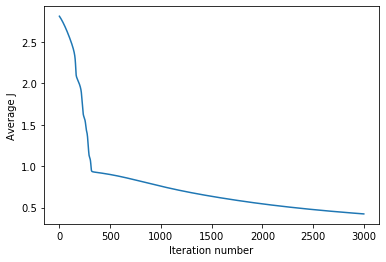

In [30]:
# plot the avg_cost_func 
plt.plot(mse_cost_overtime)
plt.xlabel('Iteration number')
plt.ylabel('Average J')
plt.show()

## Assessing accuracy
Next we determine what percentage the neural network correctly predicted the handwritten digit correctly on the test set

In [31]:
y_pred = predict_y(trained_weight, trained_bias, X_test, len(nn_structure))
print('Prediction accuracy is {:5f}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 88.456189%
